In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data, filter_sleep_nights
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction
from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

## Sleep Info

For the moment, I shall consider the self-reports for the sleep data.

In [2]:
path_to_experiment_info: str = '../data.nosync/mwc2022/all_experimento_info.csv'
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=2)
experiment_info.filter_correct_times(inplace=True)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

567

In [4]:
eda_data = filter_sleep_nights(data=eda_data, experiment_info=experiment_info.to_df())

flitering user progress:   0%|          | 0/8 [00:00<?, ?it/s]

Removed 9 sessions


In [5]:
users = get_all_users(eda_data)
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    
    sessions_all_left = sorted(eda_data["left"][user].index.get_level_values(0).unique())
    sessions_all_right = sorted(eda_data["right"][user].index.get_level_values(0).unique())
    sessions_all = sorted(set(sessions_all_left) & set(sessions_all_right))
    
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="mwc2022",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


Plotting user data:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

In [6]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info.to_dict(),
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
    mode=experiment_info.get_mode(),
)


User progress:   0%|          | 0/8 [00:00<?, ?it/s]

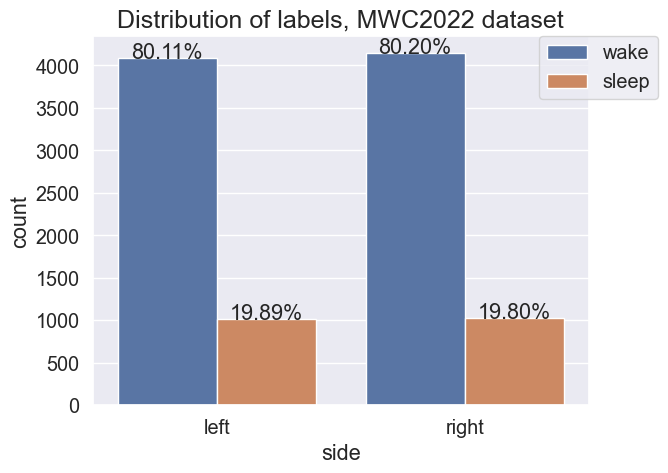

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['sleep', 'wake'])

plot_binary_labels(
    counts=counts,
    title="Distribution of labels, MWC2022 dataset",
    dataset_name="mwc2022",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [9]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(inf

In [11]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(5103, 11)
labels_left.shape=(5103,)
groups_left.shape=(5103,)


## ML Prediction

In [53]:
from typing import Callable
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)

def resampling(df: DataFrame, resampling_method: BaseUnderSampler = RandomUnderSampler, random_state: int = 42) -> DataFrame:
    x = df.drop(columns=["label"], inplace=False).values
    y = df["label"].values
    cc = resampling_method(random_state=random_state)
    x_resampled, y_resampled = cc.fit_resample(x, y)
    result = DataFrame(x_resampled)
    result['label'] = y_resampled
    return result

### 5-fold CV

In [54]:
from sklearn.model_selection import KFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
def run_cv_ml(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values


    folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    return pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

#### LX v LX

In [55]:
run_cv_ml(features_left, labels_left, groups_left)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 16.82it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                    0.76              0.76    0.76     0.76   
RandomForestClassifier            0.76              0.76    0.76     0.76   
SVC                               0.75              0.76    0.76     0.75   
NuSVC                             0.75              0.75    0.75     0.75   
ExtraTreesClassifier              0.75              0.75    0.75     0.75   
XGBClassifier                     0.75              0.75    0.75     0.75   
CalibratedClassifierCV            0.75              0.75    0.75     0.75   
KNeighborsClassifier              0.74              0.74    0.74     0.74   
AdaBoostClassifier                0.74              0.74    0.74     0.74   
LogisticRegression                0.74              0.74    0.74     0.74   
LinearSVC                         0.74              0.74    0.74     0.73   
LabelPropagation                  0.73              0.73    0.73     0.73   
RidgeClassifierCV                 0.73              0.73    0.73     0.73   
LabelSpreading                    0.73              0.73    0.73     0.73   
LinearDiscriminantAnalysis        0.73              0.73    0.73     0.72   
RidgeClassifier                   0.73              0.73    0.73     0.72   
SGDClassifier                     0.73              0.73    0.73     0.72   
BaggingClassifier                 0.73              0.73    0.73     0.73   
BernoulliNB                       0.70              0.70    0.70     0.70   
NearestCentroid                   0.69              0.69    0.69     0.68   
DecisionTreeClassifier            0.67              0.67    0.67     0.67   
ExtraTreeClassifier               0.67              0.67    0.67     0.67   
Perceptron                        0.67              0.67    0.67     0.65   
GaussianNB                        0.67              0.67    0.67     0.65   
PassiveAggressiveClassifier       0.65              0.66    0.66     0.64   
QuadraticDiscriminantAnalysis     0.65              0.65    0.65     0.64   
DummyClassifier                   0.49              0.50    0.50     0.32   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                      0.48           0.01              0.01   
RandomForestClassifier              0.24           0.01              0.01   
SVC                                 0.06           0.01              0.01   
NuSVC                               0.07           0.01              0.01   
ExtraTreesClassifier                0.12           0.01              0.01   
XGBClassifier                       0.10           0.01              0.01   
CalibratedClassifierCV              0.26           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
AdaBoostClassifier                  0.10           0.00              0.00   
LogisticRegression                  0.01           0.01              0.01   
LinearSVC                           0.07           0.01              0.01   
LabelPropagation                    0.03           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
LabelSpreading                      0.04           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
SGDClassifier                       0.01           0.01              0.01   
BaggingClassifier                   0.07           0.01              0.01   
BernoulliNB                         0.00           0.01              0.01   
NearestCentroid           

#### RX vs RX

In [56]:
run_cv_ml(features_right, labels_right, groups_right)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 14.89it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                    0.72              0.72    0.72     0.72   
RandomForestClassifier            0.72              0.72    0.72     0.72   
ExtraTreesClassifier              0.72              0.72    0.72     0.72   
XGBClassifier                     0.72              0.72    0.72     0.71   
AdaBoostClassifier                0.71              0.71    0.71     0.71   
NuSVC                             0.71              0.71    0.71     0.70   
SVC                               0.70              0.70    0.70     0.70   
BaggingClassifier                 0.70              0.70    0.70     0.70   
LogisticRegression                0.69              0.69    0.69     0.69   
KNeighborsClassifier              0.69              0.69    0.69     0.69   
CalibratedClassifierCV            0.69              0.69    0.69     0.68   
LinearSVC                         0.69              0.69    0.69     0.68   
LinearDiscriminantAnalysis        0.68              0.68    0.68     0.67   
RidgeClassifier                   0.68              0.68    0.68     0.67   
RidgeClassifierCV                 0.68              0.68    0.68     0.67   
LabelPropagation                  0.68              0.68    0.68     0.68   
LabelSpreading                    0.68              0.68    0.68     0.67   
SGDClassifier                     0.66              0.66    0.66     0.65   
DecisionTreeClassifier            0.65              0.65    0.65     0.65   
ExtraTreeClassifier               0.64              0.64    0.64     0.64   
BernoulliNB                       0.63              0.63    0.63     0.62   
QuadraticDiscriminantAnalysis     0.63              0.62    0.62     0.61   
Perceptron                        0.62              0.62    0.62     0.62   
GaussianNB                        0.62              0.62    0.62     0.59   
NearestCentroid                   0.61              0.61    0.61     0.59   
PassiveAggressiveClassifier       0.60              0.60    0.60     0.58   
DummyClassifier                   0.49              0.50    0.50     0.32   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                      0.50           0.01              0.01   
RandomForestClassifier              0.25           0.01              0.01   
ExtraTreesClassifier                0.13           0.01              0.01   
XGBClassifier                       0.10           0.01              0.01   
AdaBoostClassifier                  0.10           0.01              0.01   
NuSVC                               0.10           0.01              0.01   
SVC                                 0.07           0.01              0.01   
BaggingClassifier                   0.07           0.01              0.01   
LogisticRegression                  0.01           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
CalibratedClassifierCV              0.27           0.01              0.01   
LinearSVC                           0.07           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
LabelPropagation                    0.03           0.00              0.00   
LabelSpreading                      0.04           0.01              0.00   
SGDClassifier                       0.01           0.03              0.03   
DecisionTreeClassifier              0.01           0.01              0.01   
ExtraTreeClassifier       

#### LX vs RX

In [57]:
def local_resampling(x, y, groups, resampling_method: BaseUnderSampler = RandomUnderSampler):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values
    return x_resampled, y_resampled, groups

In [58]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:02<00:00, 11.43it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.70,0.70,0.70,0.70,0.21
AdaBoostClassifier,0.69,0.69,0.69,0.69,0.13
SVC,0.69,0.69,0.69,0.69,0.20
XGBClassifier,0.69,0.69,0.69,0.69,0.12
RandomForestClassifier,0.68,0.68,0.68,0.68,0.31
LogisticRegression,0.68,0.68,0.68,0.68,0.01
CalibratedClassifierCV,0.68,0.68,0.68,0.68,0.33
ExtraTreesClassifier,0.68,0.68,0.68,0.68,0.16
LGBMClassifier,0.68,0.68,0.68,0.68,0.59


#### RX vs LX

In [59]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:02<00:00, 10.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.74,0.74,0.74,0.74,0.23
RandomForestClassifier,0.73,0.73,0.73,0.73,0.32
LogisticRegression,0.73,0.73,0.73,0.73,0.01
CalibratedClassifierCV,0.72,0.72,0.72,0.72,0.34
LGBMClassifier,0.72,0.72,0.72,0.72,0.60
LinearSVC,0.72,0.72,0.72,0.72,0.09
RidgeClassifierCV,0.72,0.72,0.72,0.71,0.01
RidgeClassifier,0.72,0.72,0.72,0.71,0.01
LinearDiscriminantAnalysis,0.72,0.72,0.72,0.71,0.01


## 5-fold CV - different seeds

In [49]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed


def run_cv_ml_multiple_seeds(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 10
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    set_numpy_seed(666)
    n_seeds_to_test_folds: int = 10
    random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

    for random_state_folds in tqdm(
        random_states_folds, desc="Random states folds progress:", colour="blue"
    ):
        for random_state_classifier in tqdm(
            random_states_classifiers,
            desc="Random states classifiers progress:",
            colour="green",
        ):
            # NOTE: the fold generation should be fixed, to limit the accuracy
            # be due exclusively to starting confitions in the algorithm
            folds = StratifiedKFold(
                n_splits=5, random_state=random_state_folds, shuffle=True
            ).split(x_resampled, y_resampled)
            # TODO: we should iterate over different random states for the fold
            # generation as well, but independent from the random seeds for the algorithm
            # all_models = []
            # for train_index, test_index in folds:
            #     x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            #     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            #     clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            #     models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            #     all_models.append(models)
            from joblib import Parallel, delayed

            def run_fold(train_index, test_index):
                x_train, x_test = x_resampled[train_index], x_resampled[test_index]
                y_train, y_test = y_resampled[train_index], y_resampled[test_index]
                clf = LazyClassifier(
                    predictions=True, random_state=random_state_classifier
                )
                models, predictions = clf.fit(x_train, x_test, y_train, y_test)
                return models

            all_models = Parallel(n_jobs=-1)(
                delayed(run_fold)(train_index, test_index)
                for train_index, test_index in folds
            )

            averages = (
                pd.concat(all_models)
                .groupby(level=0)
                .mean()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_deviations = (
                pd.concat(all_models)
                .groupby(level=0)
                .std()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_errors = standard_deviations / 5**0.5
            results.append(
                pd.concat(
                    [averages, standard_errors],
                    axis=1,
                    keys=["Average", "Standard error"],
                )
            )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [51]:
result = run_cv_ml_multiple_seeds(features_left, labels_left, groups_left)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 44.28it/s]

100%|██████████| 29/29 [00:00<00:00, 46.14it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.34it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.26it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.17it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.30it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]



Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.12it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.71it/s]


In [53]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7653            0.7652  0.7652   0.7648   
RandomForestClassifier          0.7592            0.7591  0.7591   0.7587   
LGBMClassifier                  0.7504            0.7504  0.7504   0.7500   
XGBClassifier                   0.7410            0.7410  0.7410   0.7405   
BaggingClassifier               0.7401            0.7401  0.7401   0.7395   
AdaBoostClassifier              0.7192            0.7192  0.7192   0.7185   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
LabelPropagation                0.7178            0.7178  0.7178   0.7173   
KNeighborsClassifier            0.7177            0.7177  0.7177   0.7173   
NuSVC                           0.7101            0.7101  0.7101   0.7093   
DecisionTreeClassifier          0.7074            0.7074  0.7074   0.7069   
SVC                             0.6958            0.6958  0.6958   0.6953   
ExtraTreeClassifier             0.6867            0.6867  0.6867   0.6862   
LogisticRegression              0.6376            0.6376  0.6376   0.6369   
CalibratedClassifierCV          0.6373            0.6373  0.6373   0.6367   
RidgeClassifierCV               0.6345            0.6344  0.6344   0.6338   
LinearSVC                       0.6324            0.6324  0.6324   0.6317   
RidgeClassifier                 0.6299            0.6299  0.6299   0.6293   
LinearDiscriminantAnalysis      0.6271            0.6270  0.6270   0.6264   
NearestCentroid                 0.6253            0.6253  0.6253   0.6246   
BernoulliNB                     0.6216            0.6216  0.6216   0.6198   
SGDClassifier                   0.5810            0.5810  0.5810   0.5656   
Perceptron                      0.5598            0.5598  0.5598   0.5439   
PassiveAggressiveClassifier     0.5592            0.5591  0.5591   0.5314   
GaussianNB                      0.5463            0.5463  0.5463   0.4666   
QuadraticDiscriminantAnalysis   0.5392            0.5393  0.5393   0.4784   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0742         0.0014            0.0014   
RandomForestClassifier            0.1099         0.0013            0.0013   
LGBMClassifier                    0.0346         0.0012            0.0012   
XGBClassifier                     0.0733         0.0013            0.0013   
BaggingClassifier                 0.0265         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0018            0.0018   
LabelSpreading                    0.0099         0.0014            0.0014   
LabelPropagation                  0.0076         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
NuSVC                             0.0164         0.0012            0.0012   
DecisionTreeClassifier            0.0064         0.0017            0.0017   
SVC                               0.0130         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0018            0.0018   
LogisticRegression                0.0063         0.0020            0.0020   
CalibratedClassifierCV            0.1115         0.0021            0.0021   
RidgeClassifierCV                 0.0045         0.0019            0.0019   
LinearSVC                         0.0296         0.0019            0.0019   
RidgeClassifier                   0.0044         0.0019            0.0019   
LinearDiscriminantAnalysis        0.0043         0.0019            0.0019   
NearestCentroid           

### RX vs RX

In [54]:
result = run_cv_ml_multiple_seeds(features_right, labels_right, groups_right)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.33it/s]

100%|██████████| 29/29 [00:00<00:00, 46.41it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.33it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.02it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.11it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.57it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.07it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.05it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.34it/s]

100%|██████████| 29/29 [00:00<00:00, 43.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.06it/s]


In [55]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8144            0.8144  0.8144   0.8141   
RandomForestClassifier          0.8134            0.8134  0.8134   0.8132   
LGBMClassifier                  0.8083            0.8083  0.8083   0.8081   
XGBClassifier                   0.8064            0.8064  0.8064   0.8062   
BaggingClassifier               0.7993            0.7993  0.7993   0.7989   
KNeighborsClassifier            0.7829            0.7829  0.7829   0.7827   
AdaBoostClassifier              0.7738            0.7738  0.7738   0.7735   
NuSVC                           0.7703            0.7703  0.7703   0.7699   
SVC                             0.7663            0.7663  0.7663   0.7659   
DecisionTreeClassifier          0.7624            0.7624  0.7624   0.7620   
LabelSpreading                  0.7592            0.7593  0.7593   0.7587   
LabelPropagation                0.7569            0.7569  0.7569   0.7564   
ExtraTreeClassifier             0.7427            0.7427  0.7427   0.7423   
CalibratedClassifierCV          0.7047            0.7047  0.7047   0.7040   
NearestCentroid                 0.7010            0.7010  0.7010   0.7004   
BernoulliNB                     0.6989            0.6989  0.6989   0.6982   
LinearDiscriminantAnalysis      0.6966            0.6966  0.6966   0.6961   
GaussianNB                      0.6961            0.6960  0.6960   0.6934   
LinearSVC                       0.6915            0.6914  0.6914   0.6908   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6908   
LogisticRegression              0.6914            0.6914  0.6914   0.6908   
RidgeClassifier                 0.6907            0.6907  0.6907   0.6901   
SGDClassifier                   0.6372            0.6372  0.6372   0.6294   
Perceptron                      0.6114            0.6114  0.6114   0.6019   
PassiveAggressiveClassifier     0.6103            0.6103  0.6103   0.5937   
QuadraticDiscriminantAnalysis   0.6078            0.6078  0.6078   0.5834   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0710         0.0012            0.0012   
RandomForestClassifier            0.1069         0.0014            0.0014   
LGBMClassifier                    0.0358         0.0014            0.0014   
XGBClassifier                     0.0702         0.0013            0.0013   
BaggingClassifier                 0.0258         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0013            0.0013   
NuSVC                             0.0127         0.0017            0.0017   
SVC                               0.0113         0.0016            0.0016   
DecisionTreeClassifier            0.0065         0.0015            0.0015   
LabelSpreading                    0.0102         0.0015            0.0015   
LabelPropagation                  0.0077         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0017            0.0017   
CalibratedClassifierCV            0.1130         0.0017            0.0017   
NearestCentroid                   0.0040         0.0017            0.0017   
BernoulliNB                       0.0040         0.0017            0.0017   
LinearDiscriminantAnalysis        0.0043         0.0016            0.0016   
GaussianNB                        0.0039         0.0021            0.0021   
LinearSVC                         0.0296         0.0016            0.0016   
RidgeClassifierCV         

## LOSO

### Support

In [60]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [61]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
    
def run_same_side_classifications(x, y, folds):
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = RandomUnderSampler(random_state=42)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    # del x_with_folds_resampled
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [62]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method, random_state=random_state)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = resampling_method(random_state=random_state)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [63]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 16.80it/s]


In [64]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
CalibratedClassifierCV          0.7735            0.7735  0.7735   0.7726   
LogisticRegression              0.7665            0.7665  0.7665   0.7646   
RidgeClassifier                 0.7636            0.7636  0.7636   0.7604   
LinearDiscriminantAnalysis      0.7634            0.7634  0.7634   0.7602   
LinearSVC                       0.7632            0.7632  0.7632   0.7607   
RidgeClassifierCV               0.7624            0.7624  0.7624   0.7589   
NuSVC                           0.7588            0.7588  0.7588   0.7577   
SVC                             0.7579            0.7579  0.7579   0.7572   
AdaBoostClassifier              0.7503            0.7503  0.7503   0.7459   
ExtraTreesClassifier            0.7472            0.7472  0.7472   0.7413   
LGBMClassifier                  0.7414            0.7414  0.7414   0.7328   
RandomForestClassifier          0.7396            0.7396  0.7396   0.7325   
XGBClassifier                   0.7359            0.7359  0.7359   0.7288   
KNeighborsClassifier            0.7280            0.7280  0.7280   0.7219   
SGDClassifier                   0.7274            0.7274  0.7274   0.7223   
BernoulliNB                     0.7193            0.7193  0.7193   0.7163   
LabelSpreading                  0.7168            0.7168  0.7168   0.7116   
BaggingClassifier               0.7162            0.7162  0.7162   0.7117   
LabelPropagation                0.7152            0.7152  0.7152   0.7099   
NearestCentroid                 0.7059            0.7059  0.7059   0.6979   
GaussianNB                      0.6676            0.6676  0.6676   0.6491   
PassiveAggressiveClassifier     0.6597            0.6597  0.6597   0.6356   
Perceptron                      0.6490            0.6490  0.6490   0.6317   
ExtraTreeClassifier             0.6484            0.6484  0.6484   0.6454   
QuadraticDiscriminantAnalysis   0.6428            0.6428  0.6428   0.6316   
DecisionTreeClassifier          0.6401            0.6401  0.6401   0.6358   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
CalibratedClassifierCV            0.2998         0.0088            0.0088   
LogisticRegression                0.0075         0.0091            0.0091   
RidgeClassifier                   0.0046         0.0085            0.0085   
LinearDiscriminantAnalysis        0.0054         0.0085            0.0085   
LinearSVC                         0.0771         0.0089            0.0089   
RidgeClassifierCV                 0.0048         0.0085            0.0085   
NuSVC                             0.0769         0.0084            0.0084   
SVC                               0.0593         0.0080            0.0080   
AdaBoostClassifier                0.1090         0.0112            0.0112   
ExtraTreesClassifier              0.1409         0.0101            0.0101   
LGBMClassifier                    0.0590         0.0110            0.0110   
RandomForestClassifier            0.2687         0.0105            0.0105   
XGBClassifier                     0.2088         0.0105            0.0105   
KNeighborsClassifier              0.0088         0.0096            0.0096   
SGDClassifier                     0.0071         0.0100            0.0100   
BernoulliNB                       0.0043         0.0077            0.0077   
LabelSpreading                    0.0521         0.0083            0.0083   
BaggingClassifier                 0.0809         0.0091            0.0091   
LabelPropagation                  0.0326         0.0082            0.0082   
NearestCentroid           

### Test with different seeds (RX vs RX)

In [65]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 15.72it/s]


In [66]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7100            0.7100  0.7100   0.7052   
LogisticRegression              0.6970            0.6970  0.6970   0.6897   
AdaBoostClassifier              0.6968            0.6968  0.6968   0.6949   
LinearSVC                       0.6941            0.6941  0.6941   0.6848   
CalibratedClassifierCV          0.6922            0.6922  0.6922   0.6853   
RidgeClassifierCV               0.6881            0.6881  0.6881   0.6778   
RidgeClassifier                 0.6878            0.6878  0.6878   0.6780   
LinearDiscriminantAnalysis      0.6872            0.6872  0.6872   0.6774   
NuSVC                           0.6794            0.6794  0.6794   0.6770   
RandomForestClassifier          0.6698            0.6698  0.6698   0.6680   
KNeighborsClassifier            0.6697            0.6697  0.6697   0.6682   
XGBClassifier                   0.6672            0.6672  0.6672   0.6653   
LabelSpreading                  0.6663            0.6663  0.6663   0.6634   
ExtraTreesClassifier            0.6622            0.6622  0.6622   0.6605   
SGDClassifier                   0.6618            0.6618  0.6618   0.6475   
LabelPropagation                0.6617            0.6617  0.6617   0.6589   
BernoulliNB                     0.6496            0.6496  0.6496   0.6367   
LGBMClassifier                  0.6487            0.6487  0.6487   0.6467   
NearestCentroid                 0.6486            0.6486  0.6486   0.6295   
BaggingClassifier               0.6485            0.6485  0.6485   0.6460   
GaussianNB                      0.6375            0.6375  0.6375   0.6112   
Perceptron                      0.6094            0.6094  0.6094   0.5878   
QuadraticDiscriminantAnalysis   0.6082            0.6082  0.6082   0.5751   
DecisionTreeClassifier          0.6045            0.6045  0.6045   0.6017   
PassiveAggressiveClassifier     0.5907            0.5907  0.5907   0.5535   
ExtraTreeClassifier             0.5858            0.5858  0.5858   0.5839   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0688         0.0090            0.0090   
LogisticRegression                0.0071         0.0073            0.0073   
AdaBoostClassifier                0.1097         0.0097            0.0097   
LinearSVC                         0.0800         0.0074            0.0074   
CalibratedClassifierCV            0.3108         0.0071            0.0071   
RidgeClassifierCV                 0.0049         0.0069            0.0069   
RidgeClassifier                   0.0047         0.0070            0.0070   
LinearDiscriminantAnalysis        0.0056         0.0070            0.0070   
NuSVC                             0.1154         0.0062            0.0062   
RandomForestClassifier            0.2808         0.0072            0.0072   
KNeighborsClassifier              0.0089         0.0090            0.0090   
XGBClassifier                     0.2111         0.0089            0.0089   
LabelSpreading                    0.0545         0.0070            0.0070   
ExtraTreesClassifier              0.1465         0.0080            0.0080   
SGDClassifier                     0.0075         0.0083            0.0083   
LabelPropagation                  0.0330         0.0070            0.0070   
BernoulliNB                       0.0043         0.0075            0.0075   
LGBMClassifier                    0.0582         0.0077            0.0077   
NearestCentroid                   0.0061         0.0068            0.0068   
BaggingClassifier         

### Test with different seeds (LX vs RX)

In [67]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 24.08it/s]


In [68]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7154            0.7154  0.7154   0.7118   
NuSVC                           0.7020            0.7020  0.7020   0.6980   
LogisticRegression              0.7001            0.7001  0.7001   0.6933   
AdaBoostClassifier              0.6975            0.6975  0.6975   0.6923   
CalibratedClassifierCV          0.6975            0.6975  0.6975   0.6930   
LinearSVC                       0.6934            0.6934  0.6934   0.6838   
XGBClassifier                   0.6930            0.6930  0.6930   0.6881   
RidgeClassifierCV               0.6921            0.6921  0.6921   0.6814   
RidgeClassifier                 0.6910            0.6910  0.6910   0.6800   
LinearDiscriminantAnalysis      0.6905            0.6905  0.6905   0.6794   
ExtraTreesClassifier            0.6879            0.6879  0.6879   0.6823   
RandomForestClassifier          0.6871            0.6871  0.6871   0.6810   
LGBMClassifier                  0.6821            0.6821  0.6821   0.6762   
BaggingClassifier               0.6647            0.6647  0.6647   0.6613   
SGDClassifier                   0.6644            0.6644  0.6644   0.6539   
KNeighborsClassifier            0.6617            0.6617  0.6617   0.6560   
LabelSpreading                  0.6569            0.6569  0.6569   0.6511   
LabelPropagation                0.6539            0.6539  0.6539   0.6478   
BernoulliNB                     0.6493            0.6493  0.6493   0.6385   
NearestCentroid                 0.6431            0.6431  0.6431   0.6245   
GaussianNB                      0.6391            0.6391  0.6391   0.6140   
Perceptron                      0.6089            0.6089  0.6089   0.5864   
ExtraTreeClassifier             0.6087            0.6087  0.6087   0.6063   
PassiveAggressiveClassifier     0.6083            0.6083  0.6083   0.5771   
QuadraticDiscriminantAnalysis   0.6013            0.6013  0.6013   0.5774   
DecisionTreeClassifier          0.5983            0.5983  0.5983   0.5950   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0588         0.0095            0.0095   
NuSVC                             0.0760         0.0078            0.0078   
LogisticRegression                0.0073         0.0069            0.0069   
AdaBoostClassifier                0.1058         0.0085            0.0085   
CalibratedClassifierCV            0.2940         0.0076            0.0076   
LinearSVC                         0.0760         0.0078            0.0078   
XGBClassifier                     0.2072         0.0100            0.0100   
RidgeClassifierCV                 0.0047         0.0077            0.0077   
RidgeClassifier                   0.0046         0.0077            0.0077   
LinearDiscriminantAnalysis        0.0053         0.0077            0.0077   
ExtraTreesClassifier              0.1364         0.0100            0.0100   
RandomForestClassifier            0.2645         0.0100            0.0100   
LGBMClassifier                    0.0589         0.0097            0.0097   
BaggingClassifier                 0.0789         0.0089            0.0089   
SGDClassifier                     0.0070         0.0090            0.0090   
KNeighborsClassifier              0.0085         0.0093            0.0093   
LabelSpreading                    0.0522         0.0076            0.0076   
LabelPropagation                  0.0318         0.0080            0.0080   
BernoulliNB                       0.0041         0.0060            0.0060   
NearestCentroid           

### Test with different seeds (RX vs LX)

In [69]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.94it/s]


In [70]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LogisticRegression              0.7661            0.7661  0.7661   0.7634   
CalibratedClassifierCV          0.7626            0.7626  0.7626   0.7601   
RidgeClassifierCV               0.7625            0.7625  0.7625   0.7585   
LinearSVC                       0.7615            0.7615  0.7615   0.7581   
LinearDiscriminantAnalysis      0.7602            0.7602  0.7602   0.7561   
RidgeClassifier                 0.7602            0.7602  0.7602   0.7562   
SVC                             0.7557            0.7557  0.7557   0.7550   
RandomForestClassifier          0.7334            0.7334  0.7334   0.7302   
LGBMClassifier                  0.7277            0.7277  0.7277   0.7238   
SGDClassifier                   0.7221            0.7221  0.7221   0.7139   
NearestCentroid                 0.7210            0.7210  0.7210   0.7131   
ExtraTreesClassifier            0.7163            0.7163  0.7163   0.7131   
BernoulliNB                     0.7144            0.7144  0.7144   0.7095   
AdaBoostClassifier              0.7133            0.7133  0.7133   0.7100   
BaggingClassifier               0.7102            0.7102  0.7102   0.7076   
NuSVC                           0.6951            0.6951  0.6951   0.6934   
XGBClassifier                   0.6924            0.6924  0.6924   0.6859   
GaussianNB                      0.6829            0.6829  0.6829   0.6681   
LabelSpreading                  0.6763            0.6763  0.6763   0.6751   
LabelPropagation                0.6741            0.6741  0.6741   0.6728   
KNeighborsClassifier            0.6729            0.6729  0.6729   0.6694   
Perceptron                      0.6587            0.6587  0.6587   0.6426   
DecisionTreeClassifier          0.6582            0.6582  0.6582   0.6556   
PassiveAggressiveClassifier     0.6325            0.6325  0.6325   0.6049   
ExtraTreeClassifier             0.6219            0.6219  0.6219   0.6193   
QuadraticDiscriminantAnalysis   0.6154            0.6154  0.6154   0.5831   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LogisticRegression                0.0069         0.0091            0.0091   
CalibratedClassifierCV            0.3057         0.0093            0.0093   
RidgeClassifierCV                 0.0048         0.0089            0.0089   
LinearSVC                         0.0789         0.0091            0.0091   
LinearDiscriminantAnalysis        0.0053         0.0090            0.0090   
RidgeClassifier                   0.0046         0.0090            0.0090   
SVC                               0.0681         0.0079            0.0079   
RandomForestClassifier            0.2769         0.0083            0.0083   
LGBMClassifier                    0.0576         0.0084            0.0084   
SGDClassifier                     0.0074         0.0092            0.0092   
NearestCentroid                   0.0055         0.0078            0.0078   
ExtraTreesClassifier              0.1422         0.0084            0.0084   
BernoulliNB                       0.0041         0.0077            0.0077   
AdaBoostClassifier                0.1064         0.0084            0.0084   
BaggingClassifier                 0.0825         0.0073            0.0073   
NuSVC                             0.1145         0.0059            0.0059   
XGBClassifier                     0.2099         0.0080            0.0080   
GaussianNB                        0.0044         0.0066            0.0066   
LabelSpreading                    0.0531         0.0072            0.0072   
LabelPropagation          

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.